In [1]:
# spark session
import os
import pyspark

conf = pyspark.SparkConf()
conf.set('spark.driver.memory','4g')
conf.set('spark.network.timeout', '600s')
conf.set('spark.executor.heartbeatInterval', '120s')

sc = pyspark.SparkContext(conf=conf)
sc.setLogLevel("ERROR")
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/11 17:12:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/envs/bigdata/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
file_path = "data/cleaned_data.csv"
df = spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv(file_path)

In [3]:
df.printSchema()

root
 |-- NYPD_PCT_CD: integer (nullable = true)
 |-- BORO_NM: string (nullable = true)
 |-- RADIO_CODE: string (nullable = true)
 |-- CIP_JOBS: string (nullable = true)
 |-- INCIDENT_YEAR: integer (nullable = true)
 |-- INCIDENT_MONTH: integer (nullable = true)
 |-- TYP_DESC_HAS_TRANSIT: integer (nullable = true)
 |-- TYP_DESC_HAS_CRIME: integer (nullable = true)
 |-- TYP_DESC_HAS_KNIFE: integer (nullable = true)
 |-- TYP_DESC_HAS_CHASE: integer (nullable = true)
 |-- TYP_DESC_HAS_PROWLER: integer (nullable = true)
 |-- TYP_DESC_HAS_TRAIN: integer (nullable = true)
 |-- TYP_DESC_HAS_LARCENY: integer (nullable = true)
 |-- TYP_DESC_HAS_BURGLARY: integer (nullable = true)
 |-- TYP_DESC_HAS_HARASSMENT: integer (nullable = true)
 |-- TYP_DESC_HAS_TRAFFIC: integer (nullable = true)
 |-- TYP_DESC_HAS_ASSAULT: integer (nullable = true)
 |-- TYP_DESC_HAS_FIRE: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- WEEKDAY: integer (nullable = true)
 |-- TIME_TO_ARRIVE_FROM_DISPAT

In [4]:
#limit the dispatch to arrival time possible prediction range to 3 minutes to 40 minutes.
from pyspark.sql.functions import col
MINIMUM_PREDICTION_TIME = 3 #minutes, inclusive
MAXIMUM_PREDICTION_TIME = 40 #minutes, inclusive

df = df\
    .filter(col("TIME_TO_ARRIVE_FROM_DISPATCH") >= MINIMUM_PREDICTION_TIME)\
    .filter(col("TIME_TO_ARRIVE_FROM_DISPATCH") <= MAXIMUM_PREDICTION_TIME)

In [5]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
#string indexing desc column
columns = [
    "BORO_NM",
    "RADIO_CODE",
    "CIP_JOBS",
    "NEIGHBORHOOD"
]
indexers = [StringIndexer(inputCol=column, outputCol=column + "_INDEX") for column in columns]
pipeline = Pipeline(stages=indexers)
pipeline_model = pipeline.fit(df)
indexed_df = pipeline_model.transform(df)
indexed_df.limit(5).toPandas()


,NYPD_PCT_CD,BORO_NM,RADIO_CODE,CIP_JOBS,INCIDENT_YEAR,INCIDENT_MONTH,TYP_DESC_HAS_TRANSIT,TYP_DESC_HAS_CRIME,TYP_DESC_HAS_KNIFE,TYP_DESC_HAS_CHASE,...,TYP_DESC_HAS_ASSAULT,TYP_DESC_HAS_FIRE,HOUR,WEEKDAY,TIME_TO_ARRIVE_FROM_DISPATCH,NEIGHBORHOOD,BORO_NM_INDEX,RADIO_CODE_INDEX,CIP_JOBS_INDEX,NEIGHBORHOOD_INDEX
0,108,QUEENS,32Q1,Serious,2023,1,0,0,0,0,...,0,0,17,3,10.816667,Long Island City,2.0,11.0,2.0,11.0
1,114,QUEENS,54E1,Non CIP,2023,1,0,0,0,0,...,0,0,1,1,3.150000,Astoria,2.0,0.0,0.0,27.0
2,52,BRONX,50G1,Non CIP,2023,1,0,0,0,0,...,0,0,5,0,3.100000,Fordham,3.0,38.0,0.0,24.0
3,109,QUEENS,10H1,Non CIP,2023,1,0,1,0,0,...,0,0,15,1,7.783333,College Point,2.0,2.0,0.0,117.0
4,30,MANHATTAN,54S1,Non CIP,2023,1,0,0,0,0,...,0,0,20,3,9.316667,Harlem,1.0,18.0,0.0,1.0


In [6]:
for column in columns:
    indexed_df = indexed_df.drop(column)
indexed_df.printSchema()

root
 |-- NYPD_PCT_CD: integer (nullable = true)
 |-- INCIDENT_YEAR: integer (nullable = true)
 |-- INCIDENT_MONTH: integer (nullable = true)
 |-- TYP_DESC_HAS_TRANSIT: integer (nullable = true)
 |-- TYP_DESC_HAS_CRIME: integer (nullable = true)
 |-- TYP_DESC_HAS_KNIFE: integer (nullable = true)
 |-- TYP_DESC_HAS_CHASE: integer (nullable = true)
 |-- TYP_DESC_HAS_PROWLER: integer (nullable = true)
 |-- TYP_DESC_HAS_TRAIN: integer (nullable = true)
 |-- TYP_DESC_HAS_LARCENY: integer (nullable = true)
 |-- TYP_DESC_HAS_BURGLARY: integer (nullable = true)
 |-- TYP_DESC_HAS_HARASSMENT: integer (nullable = true)
 |-- TYP_DESC_HAS_TRAFFIC: integer (nullable = true)
 |-- TYP_DESC_HAS_ASSAULT: integer (nullable = true)
 |-- TYP_DESC_HAS_FIRE: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- WEEKDAY: integer (nullable = true)
 |-- TIME_TO_ARRIVE_FROM_DISPATCH: double (nullable = true)
 |-- BORO_NM_INDEX: double (nullable = false)
 |-- RADIO_CODE_INDEX: double (nullable = fals

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

feature_columns = [col for col in indexed_df.columns if col != "TIME_TO_ARRIVE_FROM_DISPATCH"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vector = assembler.transform(indexed_df)

train_data, test_data = df_vector.randomSplit([0.8, 0.2], seed=1234)

lr = LinearRegression(featuresCol="features", labelCol="TIME_TO_ARRIVE_FROM_DISPATCH")
evaluator = RegressionEvaluator(labelCol="TIME_TO_ARRIVE_FROM_DISPATCH", predictionCol="prediction", metricName="rmse")

lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
predictions.select("TIME_TO_ARRIVE_FROM_DISPATCH", "prediction").show()

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")



+----------------------------+------------------+
|TIME_TO_ARRIVE_FROM_DISPATCH|        prediction|
+----------------------------+------------------+
|                        5.75|13.698575939120076|
|                       35.95|13.753439527297132|
|                        5.25|10.358532592389338|
|                         9.2| 10.21242904478737|
|                       10.15|15.046810042280356|
|           38.96666666666667|13.043211319821864|
|          14.883333333333333|14.199394251699857|
|           6.716666666666667|14.433667204439018|
|          13.016666666666667|14.498540608820065|
|           7.866666666666666|14.107886971884113|
|          30.383333333333333|15.432754286551642|
|          3.0166666666666666| 9.703247599562133|
|          12.183333333333334|13.856638065068523|
|                        8.05|15.826625936702953|
|          14.366666666666667| 16.11702376292817|
|                        10.5| 13.75333906410566|
|           9.466666666666667|16.293630062567217|


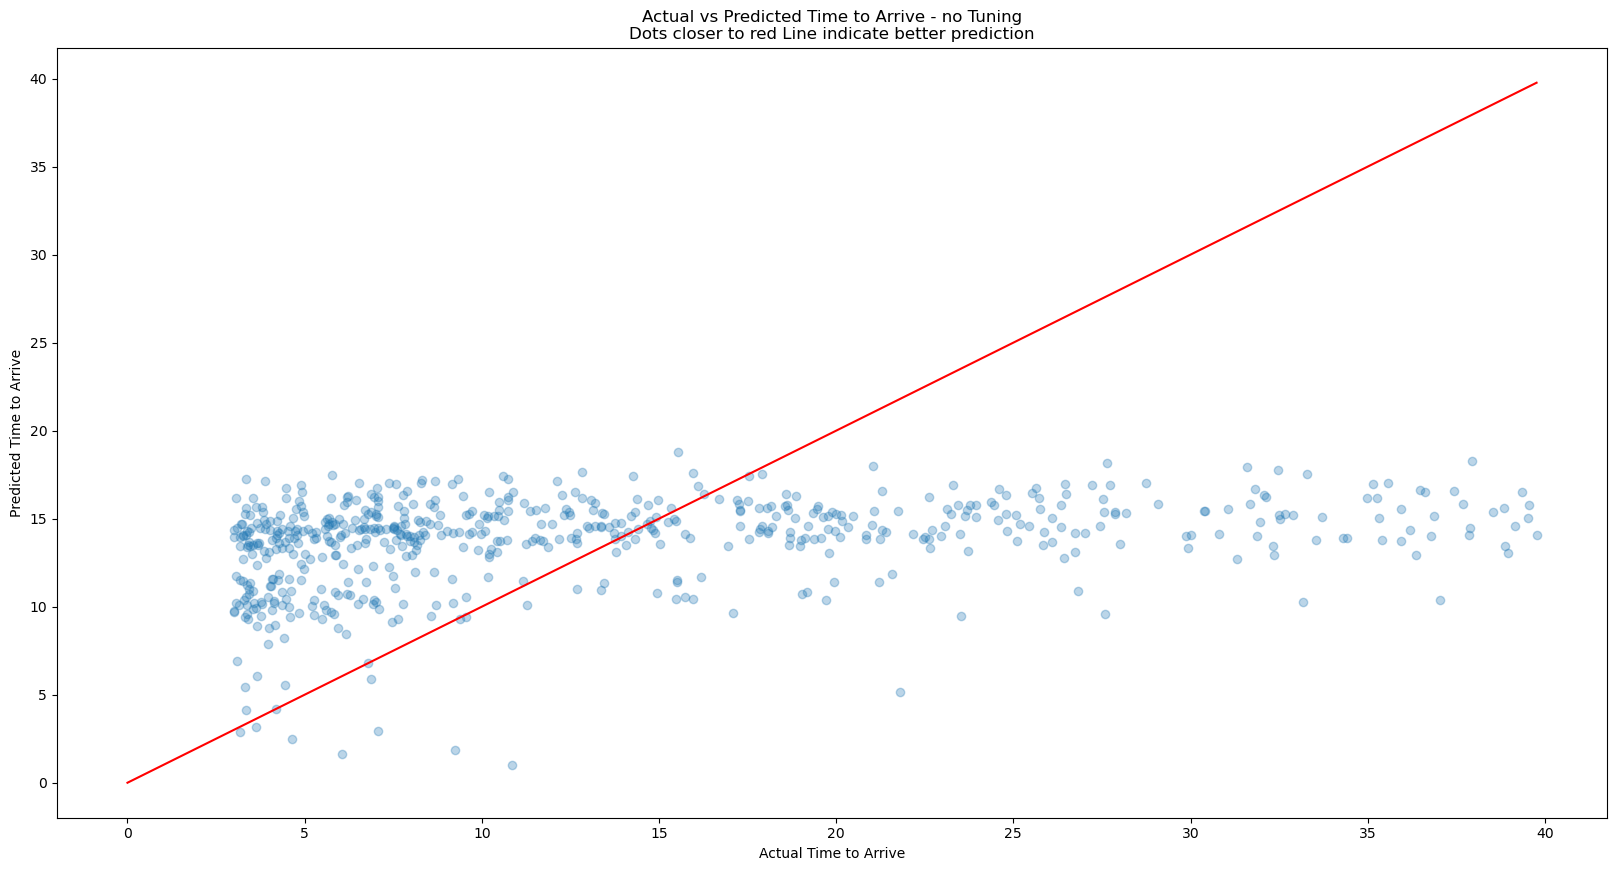

In [8]:
import matplotlib.pyplot as plt

data = predictions.select("TIME_TO_ARRIVE_FROM_DISPATCH", "prediction").toPandas()

# Plot actual vs predicted values
plt.figure(figsize=(20, 10))
plt.scatter(data['TIME_TO_ARRIVE_FROM_DISPATCH'], data['prediction'], alpha=0.3)
plt.xlabel('Actual Time to Arrive')
plt.ylabel('Predicted Time to Arrive')
maxAxis = max(max(data['TIME_TO_ARRIVE_FROM_DISPATCH']), 
              max(data['prediction']))
plt.plot([0, maxAxis], [0, maxAxis], color='red')
plt.title(f'Actual vs Predicted Time to Arrive - no Tuning\nDots closer to red Line indicate better prediction')
plt.show()

In [9]:
#PARAMETER TUNING!

# Create a ParamGridBuilder for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Create a CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Run cross-validation and choose the best set of parameters
cvModel = crossval.fit(train_data)

# Make predictions on the test set
predictions = cvModel.transform(test_data)
predictions.select("TIME_TO_ARRIVE_FROM_DISPATCH", "prediction").show()
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

+----------------------------+------------------+
|TIME_TO_ARRIVE_FROM_DISPATCH|        prediction|
+----------------------------+------------------+
|                        5.75|14.279353448444894|
|                       35.95|14.057448756238998|
|                        5.25|10.940267512500355|
|                         9.2|10.511606160291876|
|                       10.15|14.963850369416292|
|           38.96666666666667|13.891431660412692|
|          14.883333333333333| 14.56117104715456|
|           6.716666666666667|14.167959717549138|
|          13.016666666666667|14.572346766170611|
|           7.866666666666666| 14.72428221614048|
|          30.383333333333333|15.270960009480262|
|          3.0166666666666666| 9.692771357162314|
|          12.183333333333334| 13.88681102116368|
|                        8.05| 15.44445123788718|
|          14.366666666666667|15.678928873315215|
|                        10.5|14.130756649248028|
|           9.466666666666667|15.697864858627867|


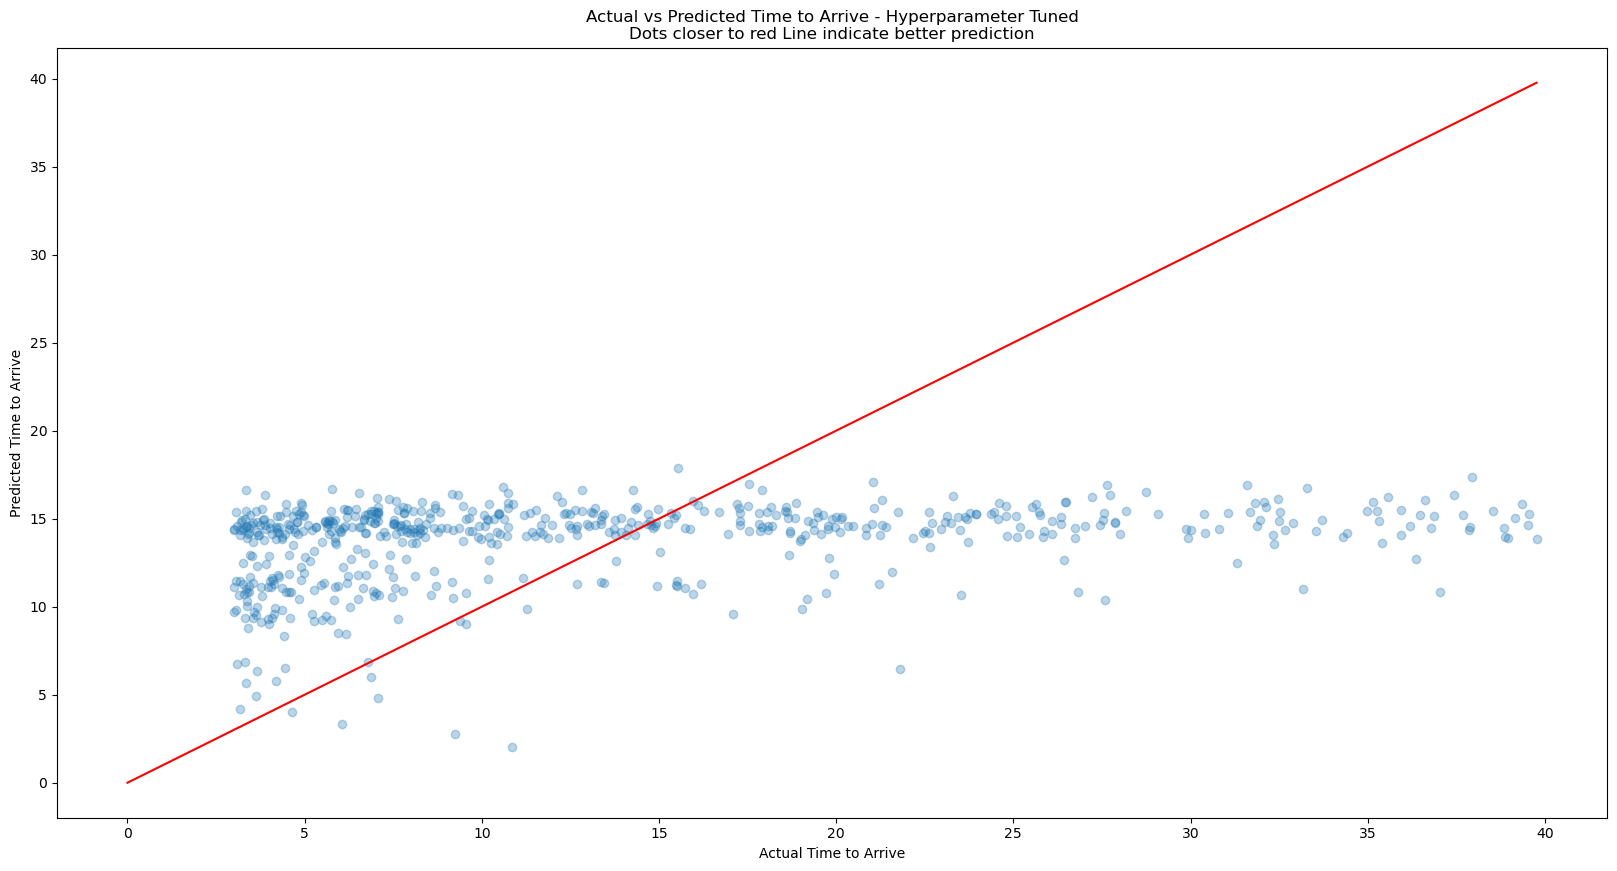

In [10]:
import matplotlib.pyplot as plt

data = predictions.select("TIME_TO_ARRIVE_FROM_DISPATCH", "prediction").toPandas()

# Plot actual vs predicted values
plt.figure(figsize=(20, 10))
plt.scatter(data['TIME_TO_ARRIVE_FROM_DISPATCH'], data['prediction'], alpha=0.3)
plt.xlabel('Actual Time to Arrive')
plt.ylabel('Predicted Time to Arrive')
maxAxis = max(max(data['TIME_TO_ARRIVE_FROM_DISPATCH']), 
              max(data['prediction']))
plt.plot([0, maxAxis], [0, maxAxis], color='red')
plt.title(f'Actual vs Predicted Time to Arrive - Hyperparameter Tuned\nDots closer to red Line indicate better prediction')
plt.show()